<a href="https://colab.research.google.com/github/aditidagar/ocular_disease_recog/blob/Adding-VGG16-model-Jupiter-files/MODEL/InceptionResNetV2_N_C_M_A_aug_contrast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/amd/')
isConcat = True

Drive already mounted at /amd/; to attempt to forcibly remount, call drive.mount("/amd/", force_remount=True).


Note:  
* edit the path to the dataset depending wehere it was saved. Aslo vgg16_weights_tf_dim_ordering_tf_kernels.h5 is avalible in the repo or you could download it by yourself.

*  vgg16_weights_tf_dim_ordering_tf_kernels.h5 should be used if it is impossible to get the weights in defining the keras.VGG16 model or for manually defined model.

In [ ]:
if isConcat:
    !cp /amd/My\ Drive/CSC490Data/ODIR-5K_aug_contrast_concat.zip /content/
    !unzip ODIR-5K_aug_contrast_concat.zip
else:
    !cp /amd/My\ Drive/CSC490Data/ODIR-5K_aug_contrast_NOFUSION.zip /content/
    !unzip ODIR-5K_aug_contrast_NOFUSION.zip 

Most of the preparation work is taken from the Grzegors model.

Grzegorz model  https://github.com/GrzegorzMeller/AlgorithmsForMassiveData


In [3]:
import os
import glob

items_to_remove = []
all_elements_train=0
all_elements_val = 0
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg" and img_label[1] != "M.jpg" and img_label[1] != "A.jpg":
    items_to_remove.append(element)
  else:
    all_elements_train+=1
  
for element in glob.glob("ODIR-5K/Validation_Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg" and img_label[1] != "M.jpg" and img_label[1] != "A.jpg":
    items_to_remove.append(element)
  else: 
    all_elements_val+=1
  
for e in items_to_remove:
  os.remove(e)

print(all_elements_train, all_elements_val)

3365 520


In [4]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_WIDTH = 250
if isConcat:
    IMG_WIDTH = 500
IMG_HEIGHT= 250
CLASS_NAMES = ['N', 'C', 'M', 'A']

In [5]:
tf.random.set_seed(10) 

In [6]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [7]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'C':
        l[1] = 1
      elif e == 'M':
        l[2] = 1
      elif e == 'A':
        l[3] = 1
  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [8]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

label:  A [0 0 0 1]
label:  A [0 0 0 1]
label:  M [0 0 1 0]
label:  N [1 0 0 0]
label:  N [1 0 0 0]
label:  A [0 0 0 1]


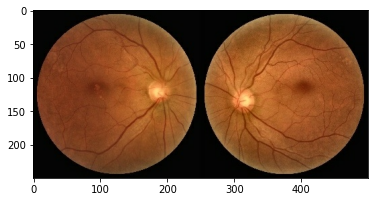

In [9]:
for image, label in resampled_named_ds.take(6):
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [10]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [11]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=3000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[0 0 1 0]


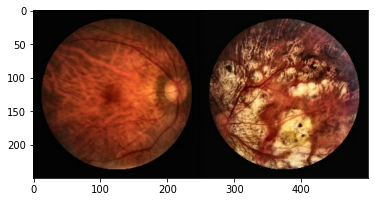

In [12]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [13]:
from tensorflow.keras.applications import InceptionResNetV2
# tf.random.set_seed(10) 
inception_res_net_v_2 = InceptionResNetV2(weights="imagenet",
                                          include_top = False,
                                          input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

In [14]:
#  TODO : if time permits I need to play around with letting few layer to be editable again
# for layer in inception_res_net_v_2.layers:
#     layer.trainable = False

In [15]:
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Flatten,Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

x = inception_res_net_v_2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax', name='softmax')(x) # 0.93 acc 0.5 loss
# output_layer = Dense(4, activation='sigmoid', name='softmax')(x)

model = Model(inputs=inception_res_net_v_2.input, outputs=output_layer)

checkpoint = ModelCheckpoint("inception_res_net_v_2_our_weights_min_augmentation.h5",monitor="val_accuracy",verbose=1, save_best_only=True, save_weights_only=False, period=1)


In [16]:
#  TODO : test with different optimizers such as SGD and Adam with different alphas
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(7) 
#  final accuracy 0.794
# note from what i have seen so far SGD converges slower and takes more time to train
# 
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 124, 249, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 249, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
if isConcat:
    history = model.fit(final_train_ds,
                        steps_per_epoch = 100, # was 220
                        epochs=15,
                        validation_data=final_test_ds,
                        validation_steps = 15,  # 33
                        verbose=1,
                        callbacks=[checkpoint]
                        )
else :
    history = model.fit(final_train_ds,
                        steps_per_epoch = 220, # was 220
                        epochs=15,
                        validation_data=final_test_ds,
                        validation_steps = 33,  # 33
                        verbose=1,
                        callbacks=[checkpoint]
                        )

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8734 - precision: 0.9255 - recall: 0.8234
Epoch 00001: val_accuracy improved from -inf to 0.90208, saving model to inception_res_net_v_2_our_weights_min_augmentation.h5
100/100 [==============================] - 129s 916ms/step - loss: 0.3525 - accuracy: 0.8734 - precision: 0.9255 - recall: 0.8234 - val_loss: 0.4340 - val_accuracy: 0.9021 - val_precision: 0.9019 - val_recall: 0.9000
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9778 - precision: 0.9787 - recall: 0.9762
Epoch 00002: val_accuracy did not improve from 0.90208
100/100 [==============================] - 82s 818ms/step - loss: 0.0664 - accuracy: 0.9778 - precision: 0.9787 - recall: 0.9762 - val_loss: 0.4312 - val_accuracy: 0.8833 - val_precision: 0.8849 - val_recall: 0.8813
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9897 - precision: 0.9897 - r

below is result when doing the categorical_crossentropy for loss

In [ ]:
model.load_weights('inception_res_net_v_2_our_weights_min_augmentation.h5')
model.evaluate(final_test_ds, steps=100)

100/100 [==============================] - 14s 143ms/step - loss: 0.6729 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397


[0.6728925108909607,
 0.9396874904632568,
 0.9396874904632568,
 0.9396874904632568]

# Clean up

In [ ]:
!rm -rf ODIR-5K_aug.zip
!rm -rf ODIR-5K/